In [1]:
%cd ..

C:\Users\Behnia2P2\Navid\Projects\dreye


In [1]:
import numpy as np
import dreye
from dreye.stimuli.hyperspectral import baden_unpacking as bu
from dreye.estimators.dependent_excitation_models import DependentExcitationFit
import matplotlib.pyplot as plt
from numpy.random import default_rng
import os

c:\users\behnia2p2\navid\projects\axolotl\axolotl\__init__.py:17: UserWarning: ATTENTION: Unable to setup necessary loris configuration to connect to database!!!
Once the issue is resolved, can connect to the database by trying to import the `conn` method: `from axolotl.sql import conn`
This is the error that popped up:
No module named 'loris_config_files'
  warnings.warn(


In [2]:
plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 100

In [3]:
raw_data_path = os.path.join(os.path.expanduser('~'), 'Navid', 'Projects', 'dreye', 'dreye', 'stimuli', 'hyperspectral', 'alldata_formatted_cactus.txt')
scanning_path_path = os.path.join(os.path.expanduser('~'), 'Navid', 'Projects', 'dreye', 'dreye', 'stimuli', 'hyperspectral', 'scanning_path.csv')

In [4]:
image_array = np.genfromtxt(raw_data_path, delimiter=',', dtype='float64', missing_values=('-inf'))
path = np.genfromtxt(scanning_path_path, delimiter=',', dtype='float64')

In [5]:
image_array.shape

(800, 1000)

In [6]:
path.shape

(2, 1000)

In [7]:
data, wls = bu.preprocess_baden(image_array)

In [8]:
WLS = np.arange(300, 700)

In [73]:
data[data < 0] = 0
spectra = dreye.Signals(data, domain=wls, domain_units='nm', units='spectralirradiance')(WLS).to('uE').smooth(10)
spectra[spectra.magnitude < 1e-4] = 1e-4

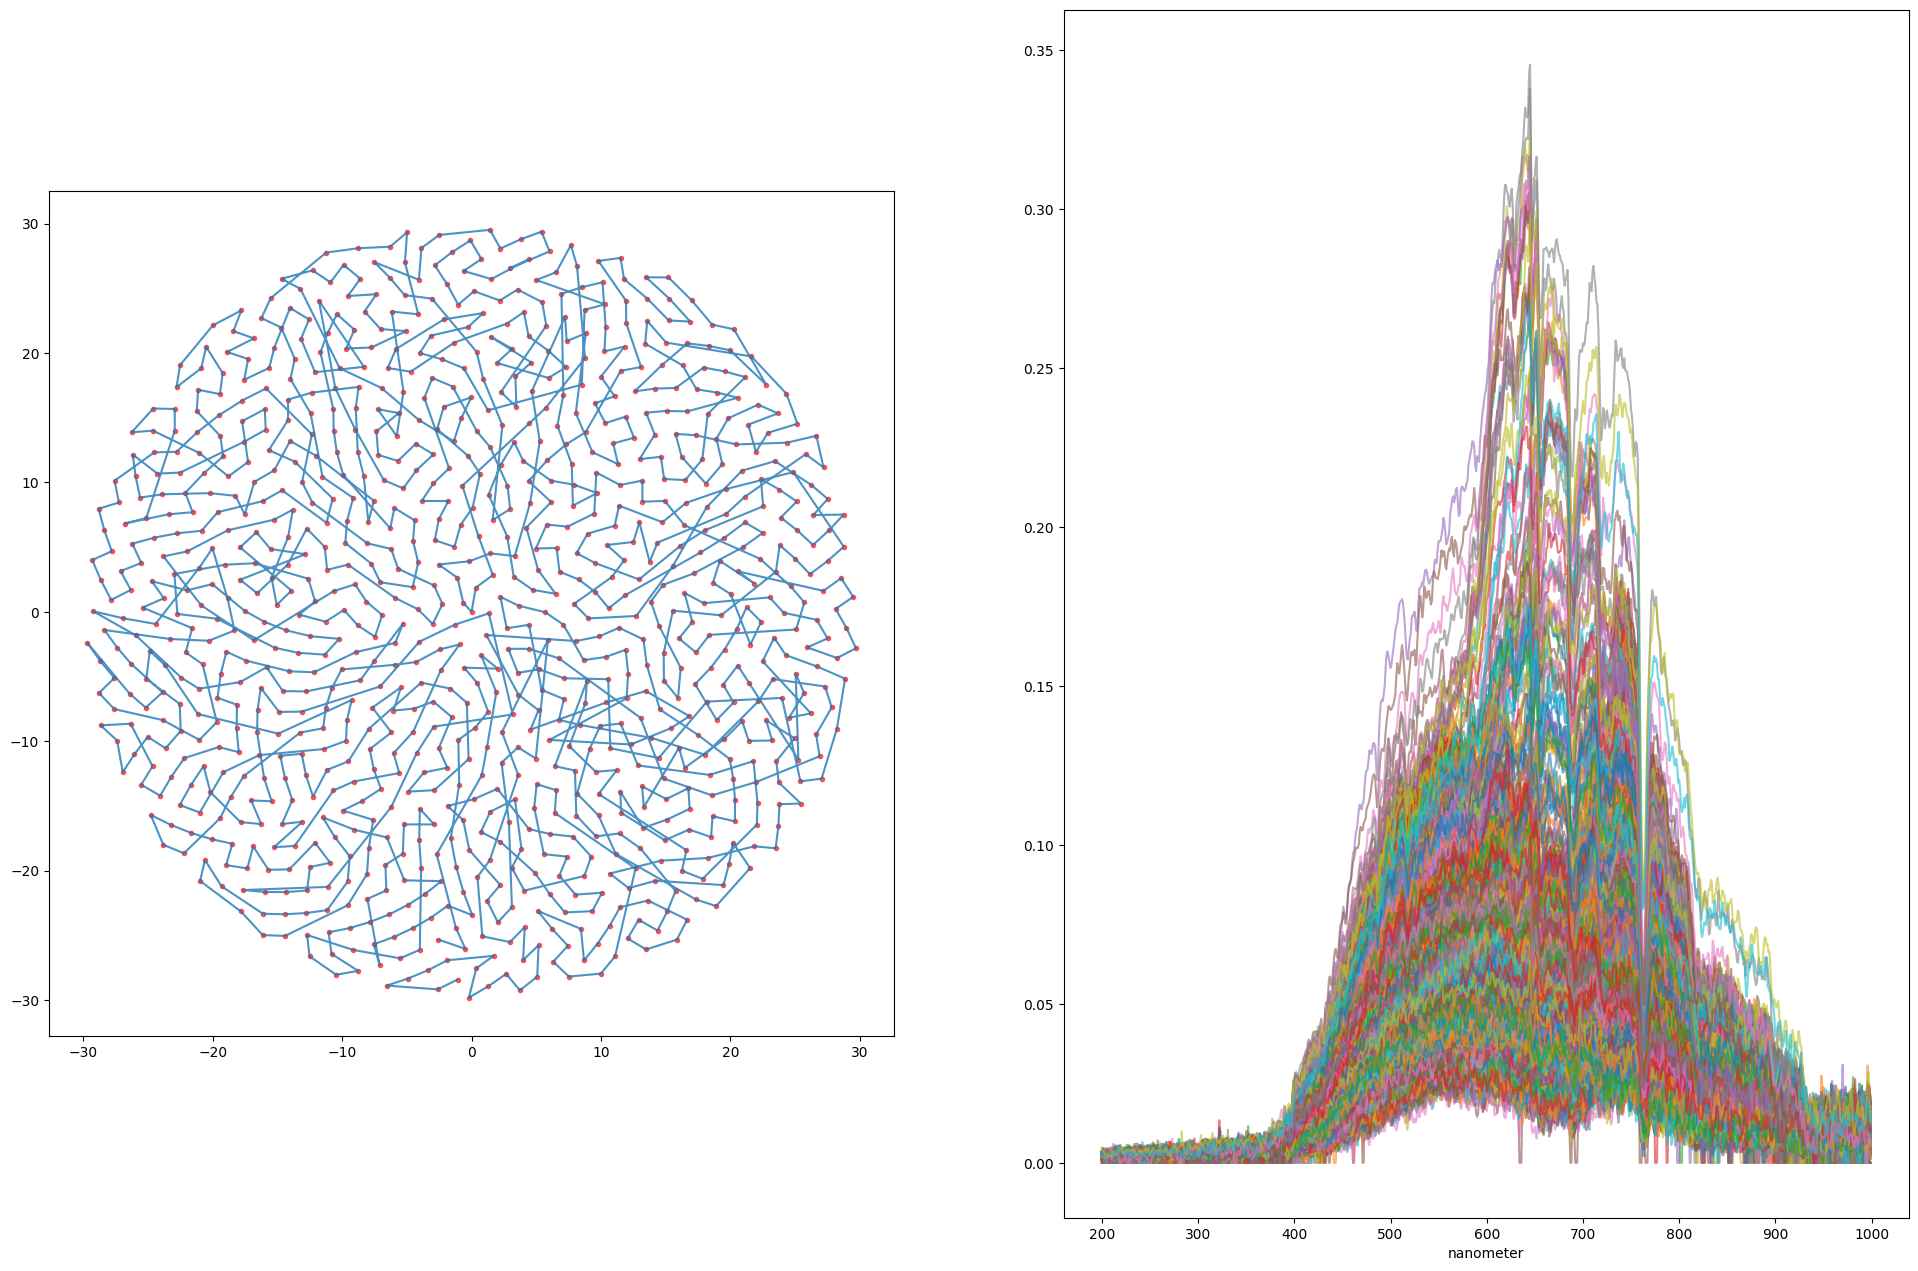

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(path[0], path[1], marker='.', color='r', linestyle='none', alpha=0.6)
ax1.plot(path[0], path[1], alpha=0.8)
ax1.set_aspect('equal', adjustable='box')

for i in range(data.shape[0]):
    ax2.plot(wls, data[:,i], alpha=0.6)

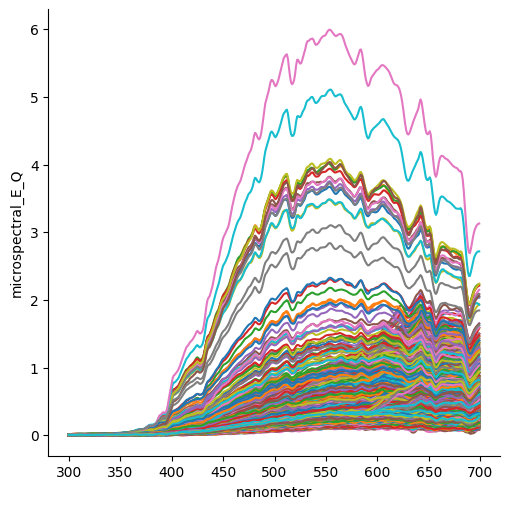

In [74]:
spectra.plot(legend=False)

In [12]:
image_size = (150, 150)

In [13]:
#initilizing vector as well as data for missing values
zero_spectra = np.array([0 for i in range(image_array.shape[0])])

In [14]:
#initialize rectangular image reconstruction matrix
reconstructed_image = np.array([zero_spectra for i in range(image_size[0] * image_size[1])]).reshape(image_size[0], image_size[1], image_array.shape[0])

In [15]:
reconstructed_image.shape

(150, 150, 800)

In [75]:
mspectra = dreye.create_measured_spectra_container(
    [380, 450, 515, 565], wavelengths=WLS
)

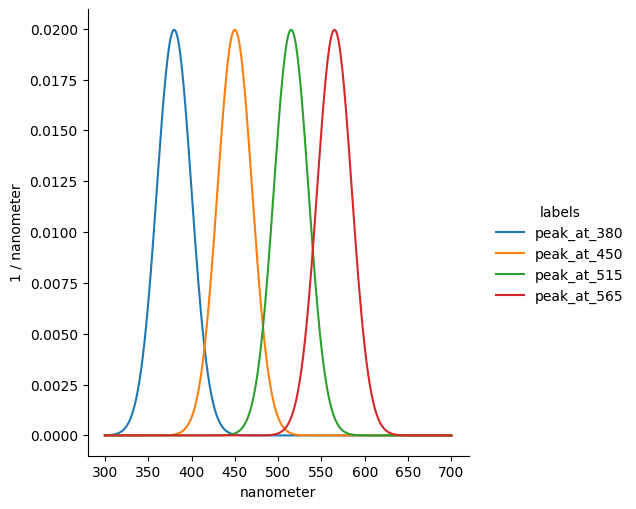

In [17]:
mspectra.normalized_spectra.plot()

In [85]:
pr_model = dreye.create_photoreceptor_model(
    [380, 450, 600], 
   photoreceptor_type='log', 
    capture_noise_level=1e-2, wavelengths=WLS
)

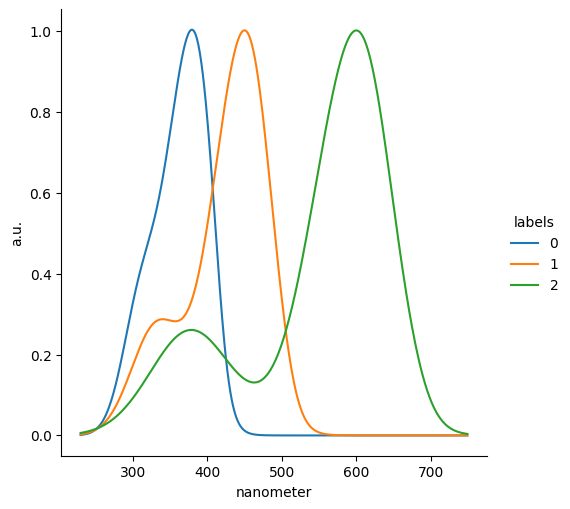

In [53]:
pr_model.sensitivity.plot()

In [77]:
# seed
rng = default_rng(14)

In [84]:
spectra.min()

0.0001 <Unit('microspectral_E_Q')>

In [98]:
X = pr_model.excitation(spectra, return_units=False, background='norm')

In [99]:
X.min()

-4.9210361285144195

In [100]:
X.shape

(1000, 3)

In [101]:
model = DependentExcitationFit(
    photoreceptor_model=pr_model, 
    measured_spectra=mspectra, 
    ignore_bounds=True, 
    bit_depth=8, 
    independent_layers=3, 
    n_epochs=5, 
    epoch_iter=5, 
    seed=100, 
    normalize_during_training=False, 
    round_during_training=False, 
    background='norm'
)

In [102]:
model.fit(X)

C:\Users\Behnia2P2\anaconda3\envs\dreye\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


DependentExcitationFit(background='norm', bit_depth=8, epoch_iter=5,
                       ignore_bounds=True, independent_layers=3,
                       measured_spectra=MeasuredSpectraContainer([[0.0 0.00022305746564480405 0.0004461149312896081 0.0006691723969344121] [0.0 0.0002721026627695109 0.0005442053255390218 0.0008163079883085326] [0.0 0.0003311029756700322 0.0006622059513400644 0.0009933089270100...8573126e-38 3.750982497146252e-38 5.626473745719377e-38] ... [0.0 2.3111333236331763e-10 4.6222666472663526e-10 6.933399970899529e-10] [0.0 1.6594529842669594e-10 3.318905968533919e-10 4.978358952800877e-10] [0.0 1.1885546873451835e-10 2.377109374690367e-10 3.5656640620355503e-10]] microspectral_E_Q),
                       n_epochs=5,
                       photoreceptor_model=LogPhotoreceptor(0, 1, 2), seed=100)

In [103]:
model.score()

0.9783430477533

In [83]:
X.min(), X.max()

(-0.47297991117120264, 6.526779391418879)

In [106]:
Xn = (X - np.min(X, 0))/(np.max(X, 0)-np.min(X, 0))

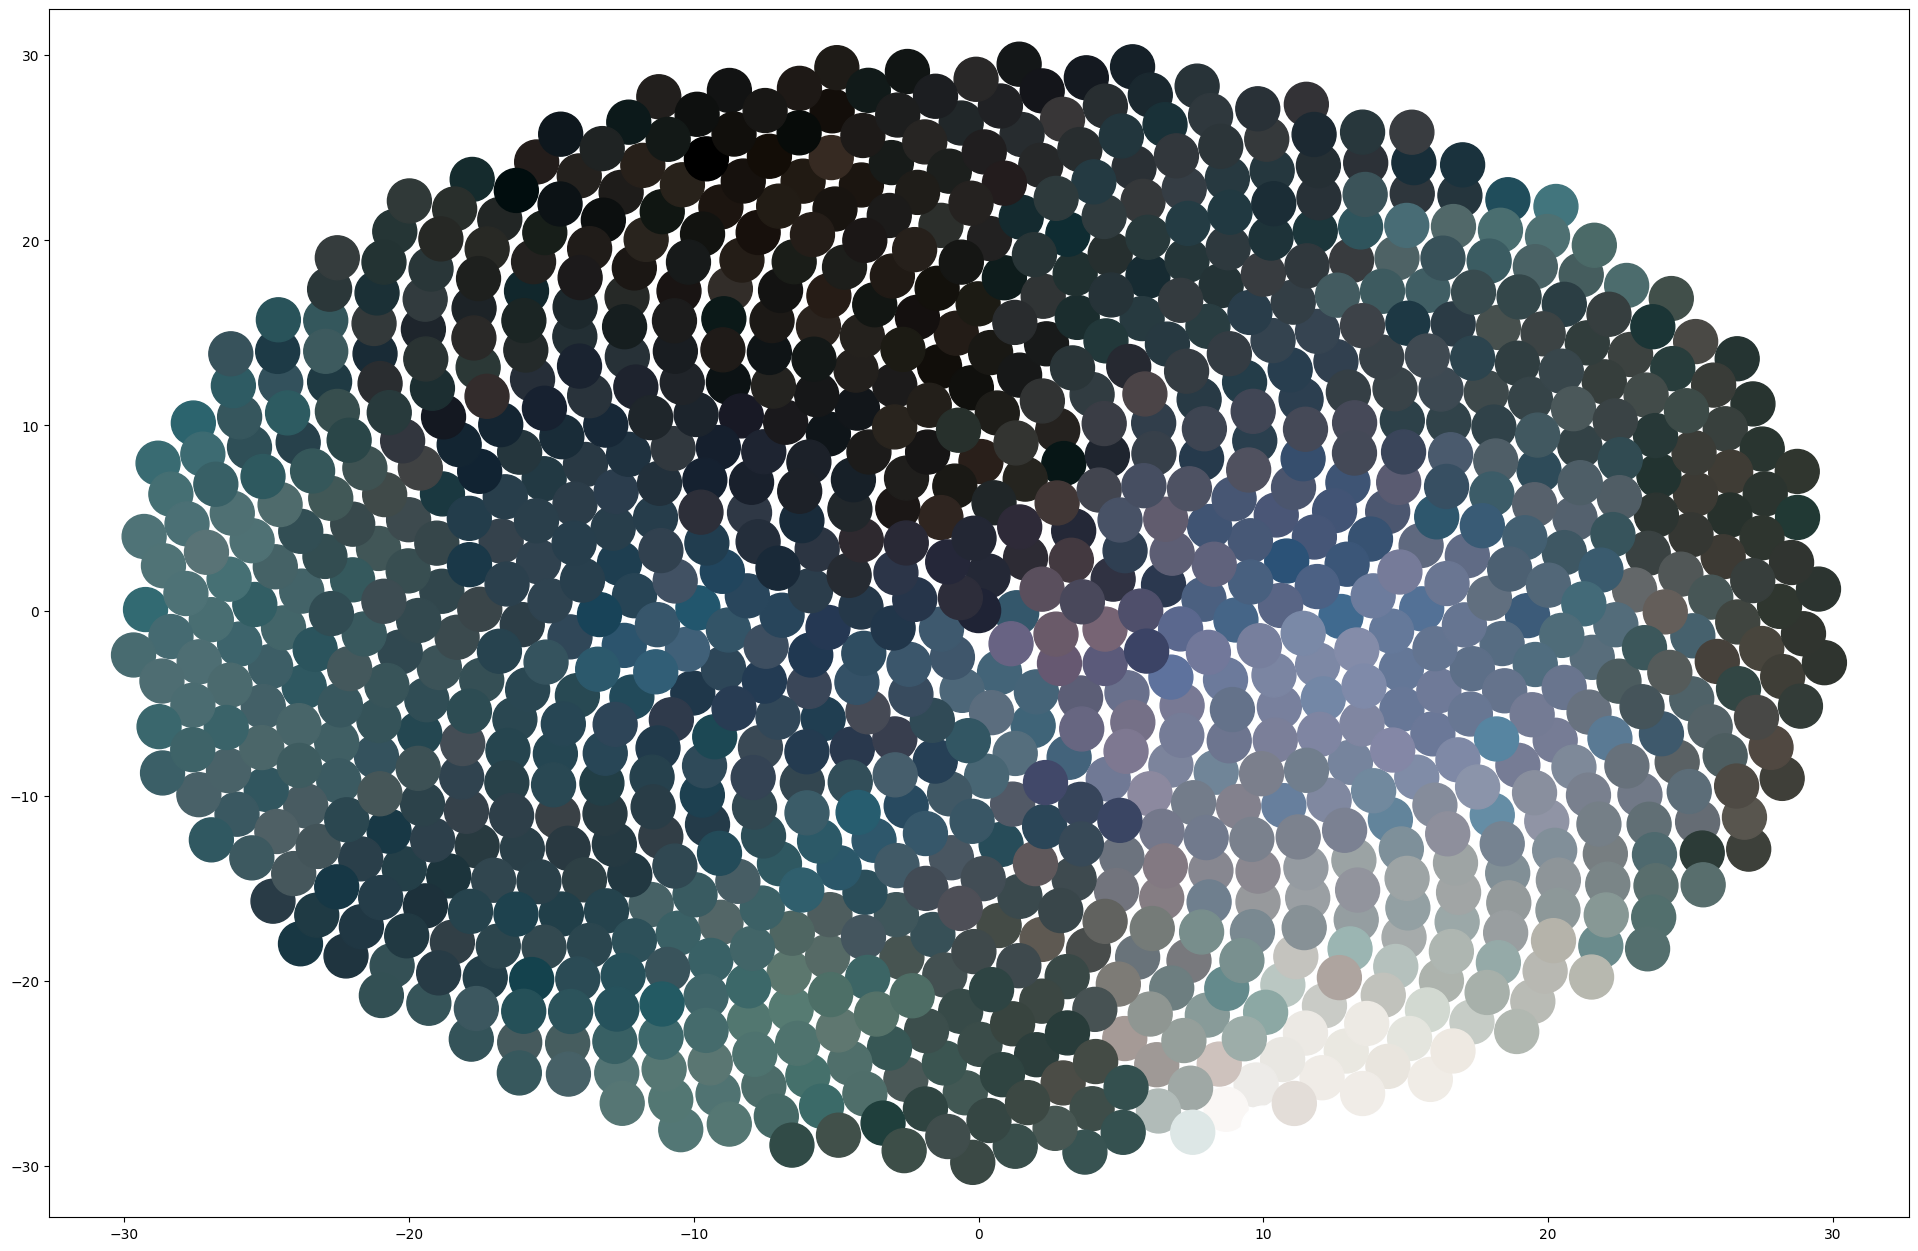

In [107]:
plt.scatter(*path, c=Xn, s=1000)

In [111]:
Xfn =  (model.fitted_X_ - np.min(X, 0))/(np.max(X, 0)-np.min(X, 0))
Xfn = np.clip(Xfn, 0, 1)

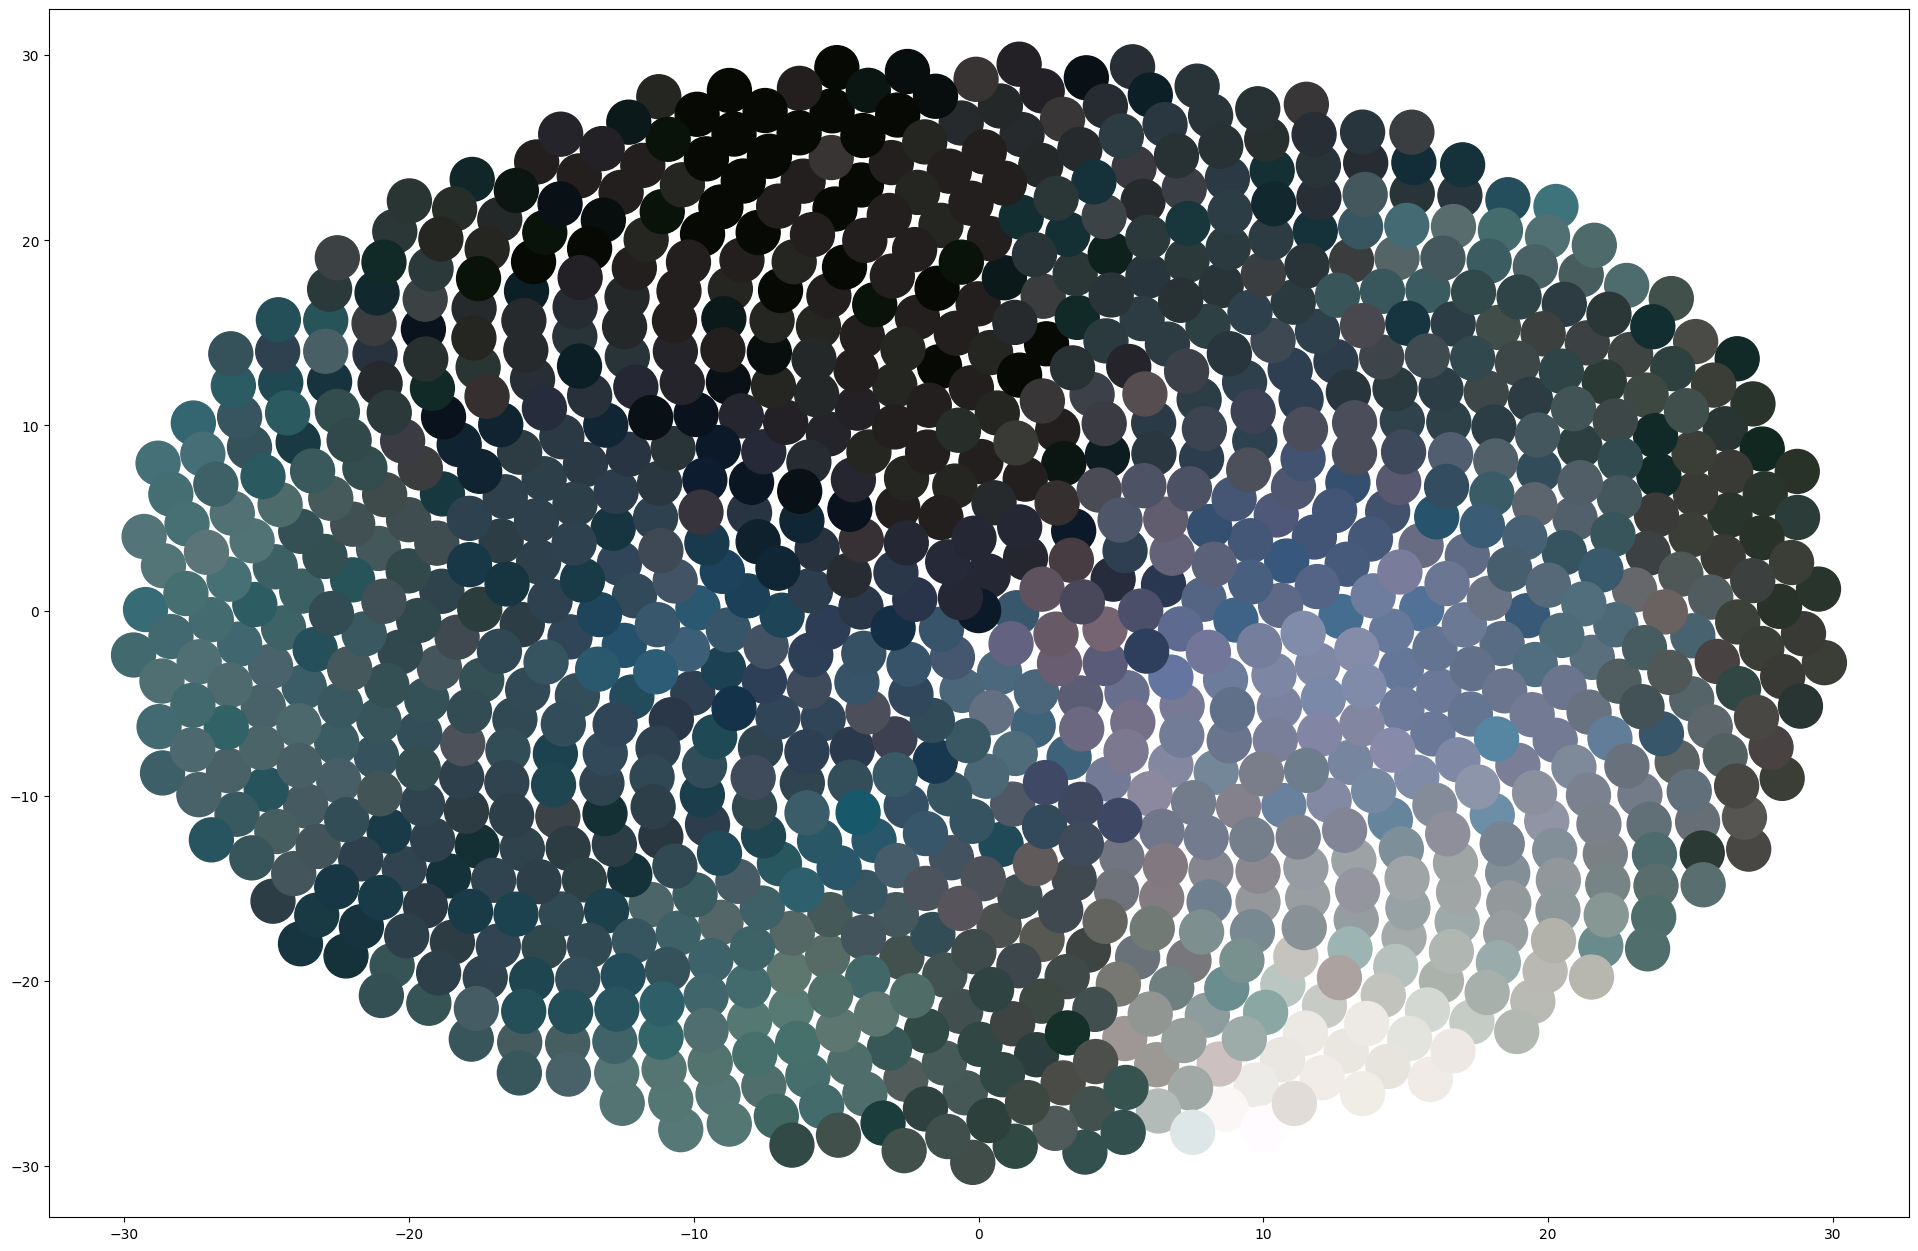

In [112]:
plt.scatter(*path, c=Xfn, s=1000)

In [25]:
# model with all LEDs available in each subframe

In [26]:
layer_assignments = [
    [0, 2], [0, 1], [1, 2], [0, 1], [1, 2], [0, 1], [0, 2]
]

In [27]:
resolution = (64, 64)
n_subframes = len(layer_assignments)
bit_depth = 5
n_pixels = resolution[0] * resolution[1]

# random weights for leds
led_weights = rng.random(
    (len(mspectra), n_subframes)
) * 40
led_weights = np.zeros(
    (len(mspectra), n_subframes)
)
for idx, idcs in enumerate(layer_assignments):
    led_weights[idcs, idx] = rng.random(len(idcs)) * 40


# normalized capture matrix
A = pr_model.capture(
    mspectra.normalized_spectra, 
    return_units=False
)

pixel_strength = rng.random((n_pixels, n_subframes))
pixel_strength = pixel_strength / np.max(pixel_strength)
pixel_strength = (np.ceil(pixel_strength * 2**bit_depth) - 1) / (2**bit_depth - 1)

X = (pixel_strength @ led_weights.T) @ A
X = pr_model.excitefunc(X)